### HW 4, Part 2, Start
### CSCI 4270 and 6270, Spring 2024

This is starter code for HW 4, Part 2. Most important is the definition of the Dataset object for loading, separately, the train, validation and test image sets. Students can use as much or as little of this as they wish and can modify it in anyway they'd like

In [2]:
import numpy as np
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset

In [3]:
def is_image(fn):
    extensions = ['.jpg', '.jpeg', '.png']
    return any(fn.lower().endswith(ext) for ext in extensions)


def find_images_in_folder(folder_path, verbose=False):
    full_image_paths = []
    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        # Check if the file is an image
        if os.path.isfile(file_path) and is_image(filename):
            # Try opening the image
            try:
                im = Image.open(file_path)
                full_image_paths.append(file_path)
                if verbose:
                    print(f"Read image: {file_path}")
            except Exception as e:
                print(f"Error failed to read {filename}: {e}")
    print(f'Returing {len(full_image_paths)} image paths')
    return full_image_paths


folder_path = "hw4_data/valid/ocean"
full_paths = find_images_in_folder(folder_path, verbose=False)

Returing 150 image paths


In [4]:
'''
Provide a Dataset object for the five class dataset.
'''

# These are empirically determined values to optimize image intensity rescaling prior to training
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

'''
The Dataset class we write must include the __init__, __len__ and __getitem__ (subscripting) 
methods.
'''


class HW4_Dataset(Dataset):
    def __init__(self, path, class_names, new_size=None, verbose=False):
        '''
        Produce a list of the full image paths and class indices for all images
        in the given set (found along the path).  Record a transform to be
        applied by the __getitem__ method to each image.
        '''
        self.full_image_paths = []
        self.class_names = class_names
        self.gt_class_idx = []
        for idx, nm in enumerate(class_names):
            folder_path = os.path.join(path, nm)
            image_paths = find_images_in_folder(folder_path, verbose)
            self.full_image_paths += image_paths
            self.gt_class_idx += [idx] * len(image_paths)

        if new_size is not None:
            self.transform = transforms.Compose([transforms.Resize(new_size),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=MEAN, std=STD)])
        else:
            self.transform = transforms.Compose([transforms.ToTensor(),
                                                 transforms.Normalize(mean=MEAN, std=STD)])

    def __len__(self):
        return len(self.full_image_paths)

    def __getitem__(self, idx):
        fp = self.full_image_paths[idx]
        class_i = self.gt_class_idx[idx]
        im = Image.open(fp)
        im = self.transform(im)
        return im, class_i


class_names = ['grass', 'ocean', 'redcarpet', 'road', 'wheatfield']

# new_size = 60   # This reduces the original 240x360 images to 60x90.  Setting it to 240 leaves the images unchanged
new_size = None  # Setting new_size to None keeps the original image size.
verbose = False

# Form all three datasets.
train_dataset = HW4_Dataset(
    "hw4_data/train", class_names, new_size=new_size, verbose=verbose)
valid_dataset = HW4_Dataset(
    "hw4_data/valid", class_names, new_size=new_size, verbose=verbose)
test_dataset = HW4_Dataset(
    "hw4_data/test", class_names, new_size=new_size, verbose=verbose)

Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths


The validation dataset has 750 images
After the shuffle the 0th image has class index 1
Image shape is (240, 360, 3)


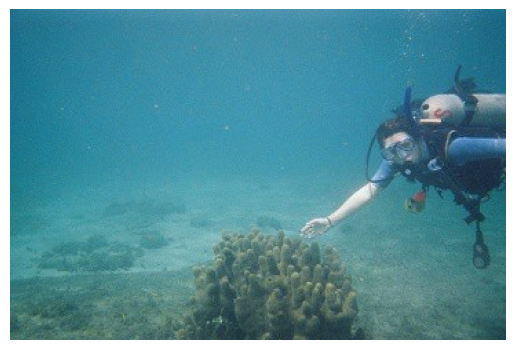

1


In [13]:
'''
Explore the constructed dataset
'''
import random
import matplotlib.pyplot as plt

# Find and output the number of images
n = len(valid_dataset)
print(f'The validation dataset has {n} images')

# Randomly shuffle the image indices
indices = list(range(n))
random.shuffle(indices)

# Get the image and the class id of the 0th image after the shuffle.
im, class_idx = valid_dataset[indices[0]]
print(f'After the shuffle the 0th image has class index {class_idx}')

# Convert the image from an array back to a numpy 3d array
im_np = im.numpy().transpose((1, 2, 0))
print(f'Image shape is {im_np.shape}')

# Before displaying the image rescale the intensities to be between 0 and 1
im_min = im_np.min()
im_max = im_np.max()
im_np = (im_np - im_min) / (im_max - im_min)

# Display the image
plt.imshow(im_np)
plt.axis('off')
plt.show()
print(class_idx)

In [14]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Adjust the fully connected layer to match the new flattened size
        self.fc1 = nn.Linear(60 * 90 * 64, 5)  # Adjusted size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 60 * 90 * 64)  # Adjusted flatten step
        x = self.fc1(x)
        return x

In [22]:
import torch.optim as optim
from torch.utils.data import DataLoader


def validate_model(model, valid_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No gradients needed
        for images, labels in valid_loader:
            labels = torch.tensor(labels, dtype=torch.long)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy


best_accuracy = 0.0
model_path = 'best_model.pth'

model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, drop_last=True)
valid_loader = DataLoader(
    valid_dataset, batch_size=32, shuffle=True, drop_last=True)

for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    # print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_dataset)}')

    accuracy = validate_model(model, valid_loader)
    # print(f'Epoch {epoch+1}, Validation Accuracy: {accuracy:.4f}')

    # Checkpointing
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        # Save model
        torch.save(model.state_dict(), model_path)
        print(
            f'Model improved and saved at epoch {epoch+1} with accuracy: {accuracy:.4f} and Loss: {running_loss/len(train_dataset)}')

print('Finished Training')

Epoch 1, Loss: 0.028132003762892314


/var/folders/c_/mn1zb83n109bc4h5r9_sng140000gn/T/ipykernel_39590/951988637.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 1, Validation Accuracy: 0.8007
Model improved and saved at epoch 1 with accuracy: 0.8007 and Loss: 0.028132003762892314
Epoch 2, Loss: 0.01559894049167633
Epoch 2, Validation Accuracy: 0.8589
Model improved and saved at epoch 2 with accuracy: 0.8589 and Loss: 0.01559894049167633
Epoch 3, Loss: 0.012654195568391254
Epoch 3, Validation Accuracy: 0.8868
Model improved and saved at epoch 3 with accuracy: 0.8868 and Loss: 0.012654195568391254
Epoch 4, Loss: 0.010847762931670462
Epoch 4, Validation Accuracy: 0.9065
Model improved and saved at epoch 4 with accuracy: 0.9065 and Loss: 0.010847762931670462
Epoch 5, Loss: 0.008331080253635135
Epoch 5, Validation Accuracy: 0.9364
Model improved and saved at epoch 5 with accuracy: 0.9364 and Loss: 0.008331080253635135
Epoch 6, Loss: 0.006660238027572631
Epoch 6, Validation Accuracy: 0.9223
Epoch 7, Loss: 0.005585240344916071
Epoch 7, Validation Accuracy: 0.9601
Model improved and saved at epoch 7 with accuracy: 0.9601 and Loss: 0.005585240344

In [23]:
import torch.nn as nn
import torch.nn.functional as F


def validate_model(model, valid_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No gradients needed
        for images, labels in valid_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy


def train(model, model_path, best_accuracy):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    train_loader = DataLoader(
        train_dataset, batch_size=32, shuffle=True, drop_last=True)
    valid_loader = DataLoader(
        valid_dataset, batch_size=32, shuffle=True, drop_last=True)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        # print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_dataset)}')

        accuracy = validate_model(model, valid_loader)
        # print(f'Epoch {epoch+1}, Validation Accuracy: {accuracy:.4f}')

        # Checkpointing
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            # Save model
            torch.save(model.state_dict(), model_path)
            print(
                f'Model improved and saved at epoch {epoch+1} with accuracy: {accuracy:.4f} and Loss: {running_loss/len(train_dataset)}')

    print('Finished Training')
    return best_accuracy


class FlexibleCNN(nn.Module):
    def __init__(self, num_conv_layers, num_fc_layers, num_classes=5):
        super(FlexibleCNN, self).__init__()

        self.features = nn.Sequential()

        # Initial input channels
        in_channels = 3
        for i in range(num_conv_layers):
            # Example: Doubling the number of channels with each layer
            out_channels = 32 * (2 ** i)
            self.features.add_module(
                f"conv{i+1}", nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            self.features.add_module(f"relu{i+1}", nn.ReLU())
            self.features.add_module(
                f"pool{i+1}", nn.MaxPool2d(kernel_size=2, stride=2))

            # Update in_channels for the next layer
            in_channels = out_channels

        # Assuming input image size is (240, 360, 3) and gets halved with each pooling
        final_image_size = (240 // (2 ** num_conv_layers),
                            360 // (2 ** num_conv_layers))
        fc_in_features = out_channels * \
            final_image_size[0] * final_image_size[1]

        # Fully connected layers
        self.classifier = nn.Sequential()
        for i in range(num_fc_layers):
            # Example: Reducing features by half if more than one layer, else match num_classes
            if i < num_fc_layers - 1:  # Not last layer
                fc_out_features = fc_in_features // 2
            else:  # Last layer
                fc_out_features = num_classes
            self.classifier.add_module(
                f"fc{i+1}", nn.Linear(fc_in_features, fc_out_features))
            if i < num_fc_layers - 1:  # Add ReLU only if it's not the last layer
                self.classifier.add_module(f"relu{i+1}", nn.ReLU())
            fc_in_features = fc_out_features

    def forward(self, x):
        x = self.features(x)
        # Flatten the tensor for the fully connected layer
        x = x.view(-1, self.classifier[0].in_features)
        x = self.classifier(x)
        return x

In [24]:
# Assuming FlexibleCNN and train are properly defined above or imported

def train_model(combination):
    CL, FC = combination
    model = FlexibleCNN(num_conv_layers=CL, num_fc_layers=FC)
    accuracy = train(model, model_path, best_accuracy)
    return accuracy, model_path


if __name__ == "__main__":
    from multiprocessing import Pool
    convLayers = [1, 2, 3, 4, 5]
    FCLayers = [1, 2, 3]
    combinations = [(cl, fc) for cl in convLayers for fc in FCLayers]

    best_accuracy = 0.0
    model_path = 'best_model.pth'

    with Pool() as pool:
        results = pool.map(train_model, combinations)

    for accuracy, path in results:
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_path = path

    print(f"Best accuracy: {best_accuracy}, Model path: {best_model_path}")

Process SpawnProcess-2:
Process SpawnProcess-1:
Process SpawnProcess-3:
Process SpawnProcess-4:
Process SpawnProcess-5:
Process SpawnProcess-6:
Process SpawnProcess-7:
Process SpawnProcess-8:
Process SpawnProcess-9:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/joshmoskoff/anaconda3/envs/aiblock/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/joshmoskoff/anaconda3/envs/aiblock/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/joshmoskoff/anaconda3/envs/aiblock/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/joshmoskoff/anaconda3/envs/aiblock/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/joshmoskoff/anacon

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.